In [1]:
%matplotlib inline

import pandas as pd
import glob
import os
import os.path as op

import networkx as nx
import random
import community

import seaborn as sns
import matplotlib.pyplot as plt

def prep_sag_fastani(fastani_out):
    '''
    Parses sag ids, 
    removes self-hits, 
    keeps only one pair-wise comparison (the one with the highest ANI) per SAG pair
    '''
    
    df = pd.read_csv(fastani_out, sep="\t", names=['c1','c2','ani','frag_mappings','total_frags'])

    df['genome1'] = [op.basename(i).split("_")[0] for i in df['c1']]
    df['genome2'] = [op.basename(i).split("_")[0] for i in df['c2']]

    df = df[df['genome1'] != df['genome2']].copy()

    pairs = []

    for i, l in df.iterrows():
        genome_pair_string = "_".join(sorted([l['genome1'], l['genome2']]))
        pairs.append(genome_pair_string)

    df['pair'] = pairs

    dedupdf = df.sort_values(by='ani', ascending=False).drop_duplicates(subset='pair', keep='first')
    return dedupdf

def cluster_fastani(df, threshold = 90):
    '''
    clusters SAGs over specified ani threshold
    '''
    subdf = df[df['ani'] >= threshold]
    nodes = list(set(list(subdf['genome1']) + list(subdf['genome2'])))
    g = nx.Graph()
    g.add_nodes_from(nodes)
    edges = [(l.genome1, l.genome2) for i, l in subdf.iterrows()]
    g.add_edges_from(edges)
    partition = community.best_partition(g)
    clusters = pd.DataFrame.from_dict(partition, orient='index').reset_index().rename(columns={"index":'sample', 0:'group'})
    return clusters

def networkx_graph(df, threshold = 90):
    '''
    Creates networkx graph from fastani 
    '''
    subdf = df[df['ani'] >= threshold]
    nodes = list(set(list(subdf['genome1']) + list(subdf['genome2'])))
    g = nx.Graph()
    g.add_nodes_from(nodes)
    edges = [(l.genome1, l.genome2) for i, l in subdf.iterrows()]
    g.add_edges_from(edges)
    return g


In [2]:
# fastANI output file. The path to this file needs to be added
fastani_out = ''

# File that has metadata related to each SAG. The columns below need to be present
sag_info_file = ''

#loading SAG table, pulling out relevant columns

# THE SSU_classification_1 here and anywhere else that it occurs probably needs to be changed to GTDB_classification or whatever that column title is
# I believe that there are five occurances of this that need to be changed
infodf = pd.read_csv(sag_info_file)[['name','Plate','SSU_classification_1','well_type']]

#Cleanup in case there are any 'no drop' or '10 cell' wells in this file
# i noticed that some control SAGs were included in the fastani analysis, so pulling a list of those out for removal from the fastani output
control_sags = list(infodf[infodf['well_type'] != '1 cell']['name'])

# just checking
print("there are", len(control_sags), "control SAGs that we don't want to be included in the fastani analysis")

In [6]:
# load fastani output
df = prep_sag_fastani(fastani_out)
df.to_csv("./tables/gom_fastani_organized.csv", index=False)
print('there are ', len(df),' genome pairs to be included in the analysis')

206441

In [4]:
### THIS CELL CAN BE REMOVED IF QC ALREADY DONE

#This is a folder of SAGs that I had initially identified as contaminated and wanted removed from the clustering

# generating a list of contaminant/cosorts to remove from fastani output 
bad_sags = [op.basename(i).split("_")[0] for i in glob.glob('/mnt/scgc/simon/microg2p/Data/SAG_contigs/contaminated_SAG_contigs/*_contigs.fasta')]

bad_sags = []

#Adding additional BAD SAGs that were identified at a later point
with open("/mnt/scgc/simon/microg2p/Data/plate_lists/contaminated_SAGs.txt") as ih:
    
    for l in ih:
        bad_sags.append(l.strip())
        
bad_sags

# just checking
print("There are", len(bad_sags), "contaminated SAGs to exclude from analysis")
print(bad_sags[:3])


# remove rows that include contaminated sags and control SAGs
remove_sags = bad_sags + control_sags

df = df[~df['genome1'].isin(remove_sags) & ~df['genome2'].isin(remove_sags)]

print('there are', len(df), 'genome pairs that are included in the analysis after the removal of bad SAGs')


['AH-135-L02',
 'AH-224-M21',
 'AH-229-E23',
 'AH-229-J06',
 'AH-229-J20',
 'AH-229-K20',
 'AH-269-A19',
 'AH-269-D11',
 'AH-269-E18',
 'AH-269-J11',
 'AH-269-J18',
 'AH-269-N03',
 'AH-545-J02',
 'AH-545-M06',
 'AH-578-G21',
 'AH-601-O09',
 'AH-603-G11',
 'AH-603-J06',
 'AH-654-B05',
 'AH-654-G08',
 'AH-654-G16',
 'AH-654-I06',
 'AH-657-P13',
 'AH-704-A15',
 'AH-704-D13',
 'AH-707-D22',
 'AH-707-K02',
 'AH-707-P01',
 'AH-709-P09',
 'AH-770-O06',
 'AH-771-F11',
 'AH-773-A02',
 'AH-773-M21',
 'AH-775-I05',
 'AH-779-K06',
 'AH-781-M20',
 'AH-135-G04',
 'AH-229-B13',
 'AH-700-P17',
 'AH-704-A23',
 'AH-704-D19',
 'AH-704-F09',
 'AH-704-O20',
 'AH-707-N16',
 'AH-224-O06',
 'AH-551-O09',
 'AH-657-F10',
 'AH-541-B10',
 'AH-707-M15',
 'AH-709-A09',
 'AH-709-B15',
 'AH-709-J11',
 'AH-141-I11',
 'AH-883-E03',
 'AH-883-F02',
 'AH-888-C02',
 'AH-787-N10',
 'AH-305-P10',
 'AD-866-D03',
 'AD-866-J03',
 'AD-866-I18',
 'AD-866-D18',
 'AD-867-P11',
 'AD-867-N03',
 'AD-867-N07',
 'AD-867-P02',
 'AAA160-B

Text(0, 0.5, '# Genome Pairs')

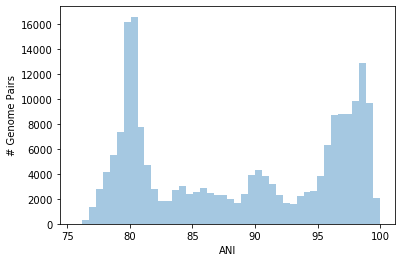

In [10]:
# just checking

sns.distplot(df['ani'], kde=False)
plt.xlabel('ANI')
plt.ylabel('# Genome Pairs')

Eyeballing ANI thresholds to look into... will use all values (aka threshold=0), 83, 87 and 93.

In [11]:
# Main ANI threshoild it will produce the output files at this level modify if necessary 
threshold = 87

clusters = cluster_fastani(df, threshold = threshold)
clusters.rename(columns = {'group':'group{}'.format(threshold)})

,sample,group87
0,AH-700-O11,0
1,AH-709-G13,1
2,AH-578-K18,2
3,AH-578-M09,3
4,AH-700-A04,4
...,...,...
3939,AH-269-I11,176
3940,AH-229-D18,24
3941,AH-141-N22,9
3942,AH-578-K15,28


In [12]:
# just checking 

clusters.head()

,sample,group
0,AH-700-O11,0
1,AH-709-G13,1
2,AH-578-K18,2
3,AH-578-M09,3
4,AH-700-A04,4


In [13]:
# merging the cluster assignments with phylogenetic information

cdf = clusters.merge(infodf, left_on='sample', right_on='name', how='left')

In [14]:
# just getting at a preview of phylogeny by group membership

cdf.groupby(['group','SSU_classification_1'])['sample'].count().reset_index()

,group,SSU_classification_1,sample
0,0,k__Eukaryota_(Chloroplast);p__?;c__?;o__?;f__?...,3
1,0,no SSU regions found,1
2,0,no SSUs were classified,1
3,1,k__Bacteria;p__Proteobacteria;c__Alphaproteoba...,160
4,1,no SSU regions found,139
...,...,...,...
586,261,no SSUs were classified,1
587,262,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...,1
588,262,no SSUs were classified,1
589,263,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...,1


Output tables...

In [15]:
# I created a possible path for this but feel free to change it.
outdir = "/mnt/scgc/simon/microg2p/Melody/BLM1/Analysis/ANI/tables/"

if not op.exists(outdir):
    !mkdir {outdir}

In [16]:
cdf.to_csv(op.join(outdir, "ani_{}_cluster_assignments_and_taxonomy.csv".format(threshold)), index=False)
df[df['ani'] >= threshold].to_csv(op.join(outdir, "ani_{}_edges.csv".format(threshold)), index=False)

Repeating this for several ANI values:

In [17]:
# set up empty dataframe which will collect the cluster information
big_cluster_dataframe = pd.DataFrame(columns = ['sample'])

# thresholds to use
thresholds = [75, 83, 87, 93, 95, 98]

# empty lists to collect information about member and cluster counts per threshold
members = []
clustercount = []


for threshold in thresholds:
    
    # subset fastani table based on threshold
    edge_table = df[df['ani'] >= threshold]
    
    # count how many SAGs are included at given threshold ... there's probably a simpler way to do this
    members.append(len(list(set(list(edge_table['genome1'].unique()) + list(edge_table['genome2'].unique())))))
    
    # cluster the table
    clusters = cluster_fastani(df, threshold = threshold)
    
    # count how many clusters resulted for given threshold
    clustercount.append(len(clusters['group'].unique()))
    
    # change group column name to designate threshold used
    clusters = clusters.rename(columns = {'group':'group{}'.format(threshold)})
    
    # merge cluster table with larger dataframe
    big_cluster_dataframe = big_cluster_dataframe.merge(clusters, how='outer')
    
    # write edge table to csv to be used in cytoscape
    edge_table.to_csv(op.join(outdir, "ani_{}_edges.csv".format(threshold)), index=False)
    
    
# merge cluster information with taxonomic information    
cdf = big_cluster_dataframe.merge(infodf, left_on='sample', right_on='name', how='left')
cdf.to_csv(op.join(outdir, "sag_all_cluster_assignments_and_info.csv"))

# create summary table
summarydf = pd.DataFrame(data={'ani_threshold':thresholds,'member_count':members,'cluster_count':clustercount})
summarydf.to_csv(op.join(outdir, "threshold_summary.csv"))
summarydf

,ani_threshold,member_count,cluster_count
0,0,4086,153
1,83,4019,238
2,87,3944,264
3,93,3796,305


In [18]:
df['ani'].min()

75.6566

Text(0.5, 0, 'ani threshold')

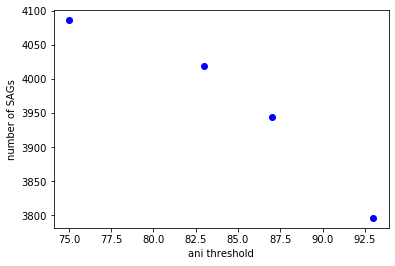

In [19]:
#substituting a threshold of 75 for 0, because that's the minimum ani reported.

plt.plot([75,83,87,93,95,98], summarydf['member_count'], 'ro', color='blue')
plt.ylabel('number of SAGs')
plt.xlabel('ani threshold')

Text(0.5, 0, 'ani threshold')

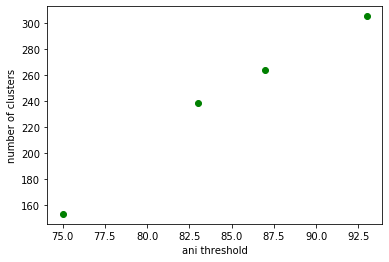

In [20]:
plt.plot([75,83,87,93,95,98], summarydf['cluster_count'], 'ro', color='green')
plt.ylabel('number of clusters')
plt.xlabel('ani threshold')

#### Before we get into categorizing SAGs, we need to address contamination, and determine what ani threshold we'll want to use.

Regarding contamination, a quick look at the networks with cytoscape suggests we still have to clean up some SAGs that might be co-sorts or otherwise contaminated.

First I want to find out how many network clusters have more than one phylogenetic group in them.

In [21]:
# change the 'no SSU...' classifications to 'None' for easier interpretation

### SAGs that are unclassified via GTDB might need to be changed as well. CHANGE the .str.contains ('**') to something in all unclassified GTDB assignments


cdf.loc[cdf['SSU_classification_1'].str.contains('no SSU'),'SSU_classification_1'] = 'None'

In [22]:
# break up classifications

### I think that this will work but This might need to be modified if the GTDB_classificaiton is using a different 
### seperator than the original SSU column was to deliminate taxonomic levels. 
### replace the "__" with whatever the speerator for GTDB is "**"

cdf['classlist'] = [i.split(";") for i in cdf['SSU_classification_1']]
cdf['kingdom'] = [i[0].split("__")[-1] for i in cdf['classlist']]
cdf['phylum'] = [i[1].split("__")[-1] if len(i) > 1 else 'None' for i in cdf['classlist']]
cdf['class'] = [i[2].split("__")[-1] if len(i) > 2 else 'None' for i in cdf['classlist']]
cdf['order'] = [i[3].split("__")[-1] if len(i) > 3 else 'None' for i in cdf['classlist']]
cdf['family'] = [i[4].split("__")[-1] if len(i) > 4 else 'None' for i in cdf['classlist']]
cdf['genus'] = [i[5].split("__")[-1] if len(i) > 5 else 'None' for i in cdf['classlist']]
cdf['species'] = [i[6].split("__")[-1] if len(i) > 6 else 'None' for i in cdf['classlist']]


In [23]:
cdf.head()

,sample,group0,group83,group87,group93,name,Plate,SSU_classification_1,well_type,classlist,kingdom,phylum,class,order,family,genus,species
0,AH-700-O11,0,0.0,0.0,NaN,AH-700-O11,AH-700,k__Eukaryota_(Chloroplast);p__?;c__?;o__?;f__?...,1 cell,"[k__Eukaryota_(Chloroplast), p__?, c__?, o__?,...",Eukaryota_(Chloroplast),?,?,?,?,?,?
1,AH-709-G13,1,1.0,1.0,0.0,AH-709-G13,AH-709,None,1 cell,[None],None,None,None,None,None,None,None
2,AH-578-K18,2,2.0,2.0,1.0,AH-578-K18,AH-578,k__Bacteria;p__Bacteroidetes;c__Sphingobacteri...,1 cell,"[k__Bacteria, p__Bacteroidetes, c__Sphingobact...",Bacteria,Bacteroidetes,Sphingobacteriia,Sphingobacteriales,NS11-12_marine_group,?,?
3,AH-578-M09,3,3.0,3.0,2.0,AH-578-M09,AH-578,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...,1 cell,"[k__Bacteria, p__Bacteroidetes, c__Flavobacter...",Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Crocinitomicaceae,Fluviicola,?
4,AH-700-A04,4,4.0,4.0,3.0,AH-700-A04,AH-700,None,1 cell,[None],None,None,None,None,None,None,None


In [24]:
# set group to examine. The # is equal to the threshold eg group95 is 95%ANI
group = 'group0'

# count group membership by taxonomy (down to family level here)
group_tax_counts = cdf.groupby([group, 'phylum','class','order','family'])['sample'].count().reset_index()

In [25]:
# check result

group_tax_counts[:20]

,group0,phylum,class,order,family,sample
0,0,?,?,?,?,3
1,0,None,None,None,None,2
2,1,None,None,None,None,274
3,1,Proteobacteria,Alphaproteobacteria,SAR11_clade,?,3
4,1,Proteobacteria,Alphaproteobacteria,SAR11_clade,Surface_1,309
5,1,Proteobacteria,Alphaproteobacteria,SAR11_clade,Surface_2,5
6,2,Bacteroidetes,Sphingobacteriia,Sphingobacteriales,NS11-12_marine_group,8
7,2,None,None,None,None,5
8,3,Bacteroidetes,Flavobacteriia,Flavobacteriales,Crocinitomicaceae,8
9,3,None,None,None,None,5


In [26]:
# remove 'none' category and count families per group
# This is a contamination check.
family_by_group = group_tax_counts[group_tax_counts['family'] != 'None'].groupby(group)['family'].count().reset_index()

family_by_group.sort_values(by='family', ascending=False)[:10]

,group0,family
1,1,3
68,74,2
34,36,2
6,7,2
0,0,1
89,99,1
85,94,1
86,95,1
87,96,1
88,98,1


Only a couple of the groups have differing family memberships... something to look into.  

Let's look at a higher tax levels to see how the result changes:

In [27]:
level = 'order'

count_by_group = group_tax_counts[group_tax_counts[level] != 'None'].groupby(group)[level].count().reset_index()

count_by_group.sort_values(by=level, ascending=False)[:10]

,group0,order
1,1,3
68,74,2
34,36,2
6,7,2
0,0,1
89,99,1
85,94,1
86,95,1
87,96,1
88,98,1


Same result.

In [28]:
level = 'class'

count_by_group = group_tax_counts[group_tax_counts[level] != 'None'].groupby(group)[level].count().reset_index()

count_by_group.sort_values(by=level, ascending=False)[:10]

,group0,class
1,1,3
68,74,2
34,36,2
6,7,2
0,0,1
89,99,1
85,94,1
86,95,1
87,96,1
88,98,1


Same result.

In [29]:
problematic_clusters = list(count_by_group[count_by_group[level] > 1 ][group])

In [30]:
print("clusters to check for contamination:", problematic_clusters)

clusters to check for contamination: [1, 7, 36, 74]


Also problematic will be nodes that connect two clusters together... these could potentially be co-sorts.

In [31]:
# add group membership to edge table

threshold = int(group[-2:])
print("Looking into contaminination using this threshold", threshold)

edgedf = df[df['ani'] >= threshold]

edgedf = edgedf.merge(cdf[["sample",group]].rename(columns={'sample':'genome1', group:'genome1_group'}), on='genome1', how='left').\
merge(cdf[["sample",group]].rename(columns={'sample':'genome2', group:'genome2_group'}), on='genome2', how='left')

ValueError: invalid literal for int() with base 10: 'p0'

In [ ]:
conflict_edges = edgedf[edgedf['genome1_group'] != edgedf['genome2_group']].copy()

In [ ]:
group_pairs = []

for i, l in conflict_edges.iterrows():
    pair = "_".join(sorted([str(l['genome1_group']), str(l['genome2_group'])]))
    group_pairs.append(pair)
    
conflict_edges['group_pairs'] = group_pairs

contam_scan = pd.concat([conflict_edges[['genome1','group_pairs']].rename(columns={'genome1':'genome'}),
         conflict_edges[['genome2','group_pairs']].rename(columns={'genome1':'genome'})]).groupby('genome')['group_pairs'].count().reset_index()

contam_scan[contam_scan['group_pairs'] > 1].sort_values(by='group_pairs', ascending=False)

AH-299-B13 has lots of connections to nodes from a different group, making it alikely culprit to be a contaminant.  The other two nodes are more ambiguous.

Next Steps would be to investigate the network using a visual tool like cytoscape and examine the problematic clusters and SAGs to determine if they are contaminated and need to be removed.  Then we can re-run this ANI analysis with a cleaner set of SAGs.